**Théo Simier - Master Project**

**Moderation of online content through Natural Language Processing, Machine Learning and Deep Learning**

In [3]:
readme = open("README.txt", "r")
contenu = readme.read()
print(contenu)

Project: Moderation of online content through Natural Language Processing, Machine Learning and Deep Learning

The objective of this master project is to illustrate:
how techniques of Natural Language Processing and Machine Learning can be used to gain meaningful information from text. 

During this thesis, I explain the most commonly used techniques and apply them on a concrete example: 
the creation of an algorithm capable of monitoring questions by checking if a question respects or not the terms and conditions of a question-and-answer website named Quora. 
I start by creating statistical features, normalizing the questions and transforming them into a format that classification algorithms can handle. 
Finally, I use a Logistic Regression, a Random Forest and a Deep Learning model to predict if the questions are compliant or not. 
The best algorithm reaches an accuracy of 87%.

The database can be found at the following url:
https://www.kaggle.com/c/quora-insincere-questions-classif

## Librairies

In [186]:
import warnings
warnings.filterwarnings("default")
import sys

# Data Manipulation
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from collections import defaultdict, Counter
import regex as re

# Vizualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Gensim
from gensim.models import KeyedVectors, Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec

# NLTK
from nltk import word_tokenize,pos_tag, pos_tag_sents
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer, LancasterStemmer

# xgboost
from xgboost import XGBClassifier

# Scikit-learn
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, Dropout, Activation, LSTM, Bidirectional, Reshape, Flatten, Concatenate,SpatialDropout1D, concatenate
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

## Importation of the dataset

In [187]:
data = pd.read_csv('train_less_100_mo.csv')
data = data.iloc[:,1:]
data.shape

(900001, 3)

In [188]:
n=50000
data_target_0 = data[data['target']==0]
data_target_1 = data[data['target']==1]
data_target_0_sample = data_target_0.sample(n=n, random_state=2) 
data_target_1_sample = data_target_1.sample(n=n, random_state=2)
data = pd.concat([data_target_0_sample,data_target_1_sample])
del data_target_0,data_target_0_sample,data_target_1,data_target_1_sample
data = shuffle(data)
data.reset_index(inplace=True, drop=True)
data.head()

,qid,question_text,target
0,5ea2ceaaab59801d1bc4,How do I become a bodybuilder in India?,0
1,4044a3c53f9a637b3fa5,How should one need to plan for the preparation of GATE ...,0
2,1279add796d613f96499,Who is the governing authority for DMV regulations and l...,0
3,4a8c305568d37e9899e3,When I'm looking for a phosphorylated protein in western...,0
4,4377c2f3971e40c32422,What are the tubes called that lead from the diesel filt...,0


In [189]:
questions = list(data['question_text'])
targets = list(data['target'])

## Description of the dataset

In [190]:
pd.set_option('max_colwidth', 600)
data.head()

,qid,question_text,target
0,5ea2ceaaab59801d1bc4,How do I become a bodybuilder in India?,0
1,4044a3c53f9a637b3fa5,How should one need to plan for the preparation of GATE 2019?,0
2,1279add796d613f96499,Who is the governing authority for DMV regulations and laws? Is it the state legislature.?,0
3,4a8c305568d37e9899e3,"When I'm looking for a phosphorylated protein in western blot, should I probe the total protein in the same membrane?",0
4,4377c2f3971e40c32422,What are the tubes called that lead from the diesel filter to the injection pump?,0


In [191]:
pd.set_option('max_colwidth', 60)

/home/theosimier/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


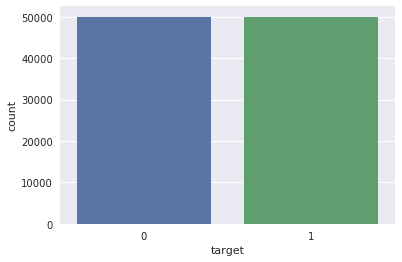

In [192]:
 sns.countplot(x=data["target"]);

# Feature Engineering

## Statistical Features

In [193]:
data.head(2)

,qid,question_text,target
0,5ea2ceaaab59801d1bc4,How do I become a bodybuilder in India?,0
1,4044a3c53f9a637b3fa5,How should one need to plan for the preparation of GATE ...,0


In [194]:
 def fct_number_words(string):
    # Count the number of words in a string
    return len(re.findall(r'\w+', string))
    
def fct_uppercases(string):
    # Count the number of uppercases in a string
    return len(re.findall(r'[A-Z]', string))

def fct_punctuations(string):
    # Count the number of punctuations in a string
    return len(re.findall(r'[.?!,;]',string))

def fct_spaces(string):
    # Count the number of spaces in a string
    return len(re.findall(r'\s', string))

def fct_digits(string):
    # Count the number of digits in a string
    return len(re.findall(r'[0-9]', string))

def fct_special_characters(string):
    # Count the number of special characters
    return len(re.findall(r'\W', string)) - fct_spaces(string) - fct_punctuations(string)

In [195]:
# Creation of a list for each statistical feature
length_question_text = data['question_text'].apply(len)
uppercases = data['question_text'].apply(fct_uppercases)/length_question_text
proportion_words = data['question_text'].apply(fct_number_words)/length_question_text
punctuations = data['question_text'].apply(fct_punctuations)/length_question_text
special_characters = data['question_text'].apply(fct_special_characters)/length_question_text
spaces = data['question_text'].apply(fct_spaces)/length_question_text
digits = data['question_text'].apply(fct_digits)/length_question_text

/home/theosimier/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/theosimier/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


/home/theosimier/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


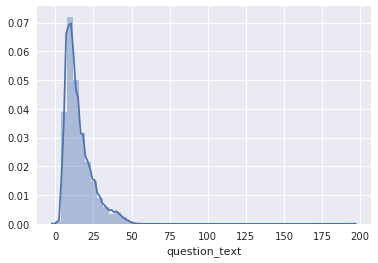

In [196]:
sns.distplot(data['question_text'].apply(fct_number_words))

In [197]:
data.iloc[0,1]

'How do I become a bodybuilder in India?'

In [198]:
data.iloc[1,1]

'How should one need to plan for the preparation of GATE 2019?'

In [199]:
# Scaler
scaler = MinMaxScaler()
# Scaling
length_question_text = scaler.fit_transform(np.asarray(length_question_text).reshape(-1,1))
uppercases = scaler.fit_transform(np.asarray(uppercases).reshape(-1,1))
proportion_words = scaler.fit_transform(np.asarray(proportion_words).reshape(-1,1))
punctuations = scaler.fit_transform(np.asarray(punctuations).reshape(-1,1))
special_characters = scaler.fit_transform(np.asarray(special_characters).reshape(-1,1))
spaces = scaler.fit_transform(np.asarray(spaces).reshape(-1,1))
digits = scaler.fit_transform(np.asarray(digits).reshape(-1,1))

/home/theosimier/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [200]:
# Scale 
# Creation of a sparce matrix
statistical_features_matrix = csr_matrix(list(zip(length_question_text.flatten(), uppercases.flatten(), proportion_words.flatten(), punctuations.flatten(), special_characters.flatten(), spaces.flatten(), digits.flatten())))
# Deleation of the lists that were included in the sparce matrix.
del length_question_text, uppercases, proportion_words, punctuations, special_characters, spaces, digits

## Normalization of the data (cleaning)

### Array not normalized

In [201]:
count_vect_not_normalized = CountVectorizer(lowercase=False, min_df=1)
# Create an object from the class CountVectorizer
# lowercase: Convert all characters to lowercase before tokenizing.
# stop_words : 'english', a built-in stop word list for English is used.
# min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.

In [202]:
data_not_normalized_matrix = count_vect_not_normalized.fit_transform(questions)
del questions
# Use the object on our data.
# Count the occurence of words for our data
# Create a sparse matrix
# We keep this data to be able to use it as a baseline.

/home/theosimier/anaconda3/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


/home/theosimier/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


We have a sparse matrix.


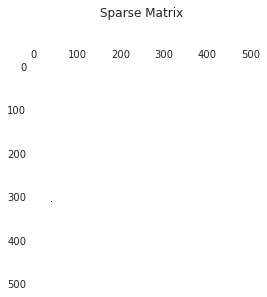

In [203]:
plt.spy(data_not_normalized_matrix[:500, :500].toarray())
plt.title("Sparse Matrix", y=1.2);
print("We have a sparse matrix.")

### Preliminary Cleaning

In [204]:
test = "  I don't buy   cheap cheese! Never less than 10$/kg.           Do you ? "

In [205]:
result = re.sub(r"\s",' ', test)  # replace ASCII spaces ( \n\r\t\f) by a simple space.
print(result)
result = re.sub(r"\'",'',result) # remove apostrophe
print(result)
result = re.sub(r'[^a-zA-Z\s]+',' ',result) # Replace everything that is not letter or space by a space
print(result)
result = re.sub(r'\s{2,}'," ",result)  # Replace double (or more) spaces by a simple space
print(result)
result = re.sub(r'^\s',"",result)  #  Remove starting spaces
print(result)
result = re.sub(r'\s$',"",result)  # Remove ending spaces
print(result)
result = result.lower()
print(result)

  I don't buy   cheap cheese! Never less than 10$/kg.           Do you ? 
  I dont buy   cheap cheese! Never less than 10$/kg.           Do you ? 
  I dont buy   cheap cheese  Never less than  kg            Do you   
 I dont buy cheap cheese Never less than kg Do you 
I dont buy cheap cheese Never less than kg Do you 
I dont buy cheap cheese Never less than kg Do you
i dont buy cheap cheese never less than kg do you


In [206]:
data["question_text"] = data["question_text"].apply(lambda x: re.sub(r"\s",' ', x))  # replace ASCII spaces ( \n\r\t\f) by a simple space.
data["question_text"] = data["question_text"].apply(lambda x: re.sub(r"\'",'', x))  # remove apostrophe
data["question_text"] = data["question_text"].apply(lambda x: re.sub(r'[^a-zA-Z\s]+',' ',x))  # Replace everything that is not letter or space by a space.
data["question_text"] = data["question_text"].apply(lambda x: re.sub(r'\s{2,}'," ",x))  # Replace double (or more) spaces by a simple space
data["question_text"] = data["question_text"].apply(lambda x: re.sub(r'^\s',"",x))  # Remove starting spaces
data["question_text"] = data["question_text"].apply(lambda x: re.sub(r'\s$',"",x))  # Remove ending spaces
data["question_text"] = data["question_text"].str.lower()  # To lower case

In [207]:
data.loc[0:5,"question_text"]

0                         how do i become a bodybuilder in india
1        how should one need to plan for the preparation of gate
2    who is the governing authority for dmv regulations and l...
3    when im looking for a phosphorylated protein in western ...
4    what are the tubes called that lead from the diesel filt...
5          why are the japanese so needy to be told theyre great
Name: question_text, dtype: object

### Tokenization

In [208]:
word_tokenize(result)

['i',
 'dont',
 'buy',
 'cheap',
 'cheese',
 'never',
 'less',
 'than',
 'kg',
 'do',
 'you']

In [209]:
data_list = list()  # List that will contain the sentences.

In [210]:
for sentence in data['question_text']:
    sentence = word_tokenize(sentence)
    data_list.append(sentence)
del data

In [211]:
data_list[:2]

[['how', 'do', 'i', 'become', 'a', 'bodybuilder', 'in', 'india'],
 ['how',
  'should',
  'one',
  'need',
  'to',
  'plan',
  'for',
  'the',
  'preparation',
  'of',
  'gate']]

### Word Frequency

In [212]:
# Set with our words
set_words = set()
for sentence in data_list:
    for word in sentence:
        if word not in set_words:
            set_words.add(word)
len(set_words)

48125

In [213]:
# Dictionnary with the count of words
frequency_words = defaultdict(int)

for key in set_words:
    frequency_words[key] = 0

for sentence in data_list:
    for word in sentence:
        frequency_words[word] += 1

In [214]:
list_frequency_words = sorted(frequency_words.items(), key=lambda x: x[1], reverse=True)
# Descending frequency of words (would work too)
#for w in sorted(frequency_words, key=frequency_words.get, reverse=True):
    #print(w, frequency_words[w])

In [215]:
# Top 50 frequency words
top_50 = list_frequency_words[:50]
top_50
# We check that they are in the set of stopwords
del list_frequency_words, frequency_words

In [216]:
top_50_stopwords = set()
for w, frequency in top_50:
    top_50_stopwords.add(w)

### Deletion of the stopwords

In [217]:
stopwords_nltk = set(stopwords.words('english')) # Stopwords of NLTK
len(stopwords_nltk)

/home/theosimier/anaconda3/lib/python3.5/site-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/home/theosimier/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


179

In [218]:
mystopwords = top_50_stopwords|stopwords_nltk  # =+ or
len(mystopwords)

185

In [219]:
top_50_stopwords - stopwords_nltk

{'get', 'like', 'people', 'trump', 'women', 'would'}

In [220]:
print("We have added {} stopwords. {}".format(len(mystopwords)-len(stopwords_nltk), top_50_stopwords - stopwords_nltk))

We have added 6 stopwords. {'women', 'get', 'like', 'people', 'would', 'trump'}


In [221]:
mystopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'like',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'o

In [222]:
# We remove the stopwords of our data_list
for i, sentence in enumerate(data_list):
    sentence = [w for w in sentence if not w in mystopwords]
    data_list[i] = sentence

In [223]:
data_list[:2]

[['become', 'bodybuilder', 'india'],
 ['one', 'need', 'plan', 'preparation', 'gate']]

### POS Tagging (Part-of-Speech Tagging)

#### Preliminary

In [224]:
pos_tag(word_tokenize("eats"))

[('eats', 'NNS')]

In [225]:
pos_tag(word_tokenize("cats"))

[('cats', 'NNS')]

In [226]:
pos_tag(word_tokenize("she loves cats"))

[('she', 'PRP'), ('loves', 'VBZ'), ('cats', 'NNS')]

In [227]:
test_list_of_list = [
    ["hello","how","are", "you"],
    ["me","i","am","fine"]
]

In [228]:
test_df_2 = pd.DataFrame([["hello how are you",0],["me i am fine",0]],columns=["question","target"])
test_list_of_list2 = []
for sentence in test_df_2['question']:
    sentence = word_tokenize(sentence)
    test_list_of_list2.append(sentence)
test_list_of_list2

[['hello', 'how', 'are', 'you'], ['me', 'i', 'am', 'fine']]

Part-of-speech constants: ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v'  
POS_LIST = [NOUN, VERB, ADJ, ADV]

In [229]:
print(wn._FILEMAP)

{'n': 'noun', 'a': 'adj', 'v': 'verb', 'r': 'adv'}


In [230]:
tag_map = defaultdict(lambda : wn.NOUN)  # Create a dictionnary with a default value of wv.NOUN
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

In [231]:
text = "what makes you start your business it is very risky and harder than being an employee"
tokens = word_tokenize(text) # We tokenize
lemmatizer = WordNetLemmatizer()  # Create the lemma object

for token, tag in pos_tag(tokens):
    lemma = lemmatizer.lemmatize(token, tag_map[tag[0]])
    print(token, "=>", lemma)

what => what
makes => make
you => you
start => start
your => your
business => business
it => it
is => be
very => very
risky => risky
and => and
harder => hard
than => than
being => be
an => an
employee => employee


**Goal: Create a set with tuple containing the word and its tag.**

In [232]:
list_token_tag = pos_tag(list(set_words))

In [233]:
token_keys = []
tag_values = []
for token, tag in list_token_tag:
    token_keys.append(token)
    tag_values.append(tag)
del list_token_tag

In [234]:
# Dictionnary that contain the token and its tag value.
tag_map_words = dict(zip(token_keys, tag_values))
del token_keys, tag_values

In [235]:
# We iterate over the first 5 keys.
i = 0
for key in tag_map_words:
    i += 1
    if i > 5:
        break
    else:
        print("{}: {}".format(key, tag_map_words[key]))

proofread: NN
nowhere: RB
voted: VBD
constituting: VBG
straitstimes: NNS


In [236]:
# The function lemmatizer.lemmatize only accept 'n', 'a', 'v', 'r' as value of the pos argument
# We need to create a dictionnary that for all possible value of the function pos_tag (in fact all first letter, 
# has a value that is valid for the function lemmatizer.
tag_map = defaultdict(lambda : wn.NOUN)  # 'n'
tag_map['J'] = wn.ADJ  # 'a'
tag_map['V'] = wn.VERB  # 'v'
tag_map['R'] = wn.ADV  # 'r'

### Stemming

In [237]:
pos_tag(word_tokenize('us'))

[('us', 'PRP')]

In [238]:
test_phrase = "what makes you start your business it is very risky and harder than being an employee"
test_list = word_tokenize(test_phrase)

In [239]:
#create an object of class PorterStemmer
porter = PorterStemmer()
lancaster=LancasterStemmer()

In [240]:
porter.stem(test_phrase)

'what makes you start your business it is very risky and harder than being an employe'

In [241]:
lancaster.stem(test_phrase)

'what makes you start your business it is very risky and harder than being an employee'

In [242]:
lancaster.stem('cats')

'cat'

In [243]:
porter.stem("car's")

"car'"

### Lemmatization

In [244]:
##### What is does ####
data_lemma_list = []
for my_list in data_list[:2]:
    lemma_list = []
    for token in my_list:
        lemma = lemmatizer.lemmatize(token, tag_map[tag_map_words[token][0]])
        lemma_list.append(lemma)
    data_lemma_list.append(lemma_list)
    print(my_list)
    print(lemma_list)

['become', 'bodybuilder', 'india']
['become', 'bodybuilder', 'india']
['one', 'need', 'plan', 'preparation', 'gate']
['one', 'need', 'plan', 'preparation', 'gate']


In [245]:
lemmatizer.lemmatize('eats', 'v')

'eat'

In [246]:
"""for token in ['eats','translate','women','are','saw','cats']:
    a = lemmatizer.lemmatize(token, tag_map[tag_map_words[token][0]])
    print(a)"""

"for token in ['eats','translate','women','are','saw','cats']:\n    a = lemmatizer.lemmatize(token, tag_map[tag_map_words[token][0]])\n    print(a)"

In [247]:
# We do the lemmatization
data_lemma_list = []  # New list of list
for my_list in data_list:
    lemma_list = []
    for token in my_list:
        lemma = lemmatizer.lemmatize(token, tag_map[tag_map_words[token][0]])
        lemma_list.append(lemma)
    data_lemma_list.append(lemma_list)
del data_list, tag_map_words

In [248]:
len(set_words)

48125

In [249]:
# Set with our words that are lemmatized.
set_lemma_words = set()
for sentence in data_lemma_list:
    for word in sentence:
        if word not in set_lemma_words:
            set_lemma_words.add(word)
length_set_lemma_words = len(set_lemma_words)
length_set_lemma_words

39076

In [250]:
print("The result of the lemmatization is that we have {} less words in our dataset.".format(len(set_words) - length_set_lemma_words))

The result of the lemmatization is that we have 9049 less words in our dataset.


In [251]:
print("We also have {} new words.".format(len(set_lemma_words - set_words)))
del set_lemma_words

We also have 1421 new words.


In [252]:
del set_words

## Extract valuable information

In [253]:
# We go from a list of list to a list of sentence.
data_lemma_string = []
for a_list in data_lemma_list:
    string = " ".join(a_list)
    data_lemma_string.append(string)

In [254]:
data_lemma_string[:2]

['become bodybuilder india', 'one need plan preparation gate']

### Bag-Of-Ngrams

#### Bag-Of-Words N-gram N=1

In [255]:
count_vect_lemma = CountVectorizer(ngram_range=(1, 1))  # Convert a collection of text documents to a matrix of token counts

In [256]:
data_lemma_matrix = count_vect_lemma.fit_transform(data_lemma_string)  # Create a sparce matrix of Bag-Of-Words

/home/theosimier/anaconda3/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


/home/theosimier/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


We have a sparse matrix.


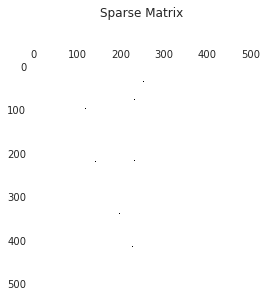

In [257]:
plt.spy(data_lemma_matrix[:500, :500].toarray())
plt.title("Sparse Matrix", y=1.2);
print("We have a sparse matrix.")

#### Bag-Of-Ngrams N-gram N=2 & N=3

In [258]:
count_vect_lemma_bigram = CountVectorizer(ngram_range=(2, 2))  # Convert a collection of text documents to a matrix of token counts
data_lemma_bigram_matrix = count_vect_lemma_bigram.fit_transform(data_lemma_string)  # Create a sparce matrix of Bag-Of-Words

/home/theosimier/anaconda3/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


In [259]:
count_vect_lemma_trigram = CountVectorizer(ngram_range=(3, 3))  # Convert a collection of text documents to a matrix of token counts
data_lemma_trigram_matrix = count_vect_lemma_trigram.fit_transform(data_lemma_string)  # Create a sparce matrix of Bag-Of-Words

/home/theosimier/anaconda3/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


In [260]:
del count_vect_lemma, count_vect_lemma_bigram, count_vect_lemma_trigram

# Modelization

## Function modelization

In [261]:
def fct_modelization(name_data_to_use, data_to_use, targets, df_results):
    print(name_data_to_use)
    # Train and test data
    x_train, x_test, y_train, y_test = train_test_split(data_to_use, targets, test_size=0.25, random_state=5)
    
    # Training of our different models
    # Logistic Regression
    print('Logistic Regression...')
    lr = LogisticRegression(random_state=0, solver='sag', max_iter=30000)
    y_pred_lr = lr.fit(x_train, y_train).predict(x_test)
    # Random forest
    print('Random Forest...')
    rfc = RandomForestClassifier(n_estimators=100,max_depth=20)
    y_pred_rfc = rfc.fit(x_train, y_train).predict(x_test)
    
    # Results of our models
    # Logistic Regression
    cm_lr = confusion_matrix(y_test,y_pred_lr)
    f1_lr = f1_score(y_test, y_pred_lr)
    accuracy_score_lr = accuracy_score(y_test, y_pred_lr)
    # Random Forest
    cm_rfc = confusion_matrix(y_test,y_pred_rfc)
    f1_rfc = f1_score(y_test, y_pred_rfc, average='binary',pos_label=1)
    accuracy_score_rfc = accuracy_score(y_test, y_pred_rfc)
    
    # We save the results
    result = [name_data_to_use,
              cm_lr, f1_lr, accuracy_score_lr,
              cm_rfc, f1_rfc, accuracy_score_rfc]
    df_results.loc[len(df_results)] = result

## Modelization

In [262]:
data_not_normalized_matrix.shape, data_lemma_matrix.shape, statistical_features_matrix.shape, data_lemma_bigram_matrix.shape, data_lemma_trigram_matrix.shape

((100000, 57405),
 (100000, 39056),
 (100000, 7),
 (100000, 444120),
 (100000, 516532))

In [263]:
# columns of the dataframe
columns_results= ['data',
                  'cm_lr','f1_lr', 'accuracy_score_lr',
                  'cm_rfc','f1_rfc','accuracy_score_rfc'
                 ]

# data that we will use during the modelization
statistical_and_lemma = hstack([statistical_features_matrix, data_lemma_matrix])
lemma_1_2_3 = hstack([data_lemma_matrix, data_lemma_bigram_matrix, data_lemma_trigram_matrix])
data_to_evaluate = [data_not_normalized_matrix,
                    statistical_features_matrix,
                    data_lemma_matrix,
                    statistical_and_lemma,
                    data_lemma_bigram_matrix,
                    data_lemma_trigram_matrix,
                    lemma_1_2_3
                   ]
name_data_to_evaluate = ['data_not_normalized_matrix',
                         'statistical_features_matrix',
                         'data_lemma_matrix',
                         'statistical_and_lemma',
                         'data_lemma_bigram_matrix',
                         'data_lemma_trigram_matrix',
                         'lemma_1_2_3'
                   ]

In [264]:
# Creation of the dataframe for the results
results = pd.DataFrame(columns=columns_results)
# We modelize
for i, data_to_use in enumerate(data_to_evaluate):
    fct_modelization(name_data_to_evaluate[i],data_to_use, targets,results)

'# Creation of the dataframe for the results\nresults = pd.DataFrame(columns=columns_results)\n# We modelize\nfor i, data_to_use in enumerate(data_to_evaluate):\n    fct_modelization(name_data_to_evaluate[i],data_to_use, targets,results)'

In [265]:
#results

### F1-Score

Confusion matrix:  (Real, Prediction)   
    True Negatives (0,0)    False Positives (0,1)  
    False Negatives (1,0)    True Positives (1,1)



F1 score:   
How many selected items are relevant ? precision = TP / (TP + FP)  
How many relevant items are selected ? recall = TP / (TP + FN)  
F1 = 2 * (precision * recall) / (precision + recall)

In [266]:
precision = results.iloc[0,1][1,1]/(results.iloc[0,1][1,1] + results.iloc[0,1][0,1])
recall = results.iloc[0,1][1,1]/(results.iloc[0,1][1,1] + results.iloc[0,1][1,0])
results.iloc[0,2] == 2*(precision*recall)/(precision + recall)

True

In [267]:
"David Hand and others criticize the widespread use of the F-score since it gives equal importance to precision and recall. In practice, different types of mis-classifications incur different costs. In other words, the relative importance of precision and recall is an aspect of the problem.[7] "

'David Hand and others criticize the widespread use of the F-score since it gives equal importance to precision and recall. In practice, different types of mis-classifications incur different costs. In other words, the relative importance of precision and recall is an aspect of the problem.[7] '

# Neural Network and words embeddings

## Preparation data

In [268]:
print("We have {} words in our dataset.".format(length_set_lemma_words))

We have 39076 words in our dataset.


In [269]:
#create new df from our standardized list
data_df = pd.DataFrame({"question_text":data_lemma_string})
data_df.head()

,question_text
0,become bodybuilder india
1,one need plan preparation gate
2,govern authority dmv regulation law state legislature
3,im look phosphorylated protein western blot probe total ...
4,tube call lead diesel filter injection pump


In [270]:
# The maximum number of words to be used
max_nb_words = length_set_lemma_words
# Max number of words in each question
max_sequence_length = 50
# This is fixed.
embedding_dimension = 100

In [271]:
my_tokenizer = Tokenizer(num_words=max_nb_words)
# num_words: the maximum number of words to keep, based on word frequencynum_words: the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.
my_tokenizer.fit_on_texts(data_df["question_text"].values)
unique_tokens = my_tokenizer.word_index
print('Found %s unique tokens.' % len(unique_tokens))

Found 39076 unique tokens.


In [272]:
X = my_tokenizer.texts_to_sequences(data_df["question_text"].values)
X = pad_sequences(X, maxlen=max_sequence_length)
print('Shape of data :', X.shape)

Shape of data : (100000, 50)


In [273]:
X[:1]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,   31, 8717,    5]], dtype=int32)

In [274]:
input_data = np.concatenate((X, statistical_features_matrix.todense()), axis=1)
del X

/home/theosimier/anaconda3/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


In [275]:
Y = np.asarray(targets)
Y = Y.reshape(-1,1)
Y.shape

(100000, 1)

In [276]:
input_data_train, input_data_test, Y_train, Y_test = train_test_split(input_data,Y, test_size = 0.10, random_state = 42)
X_train = input_data_train[:,:-7]
X_test = input_data_test[:,:-7]
statistical_features_train = input_data_train[:,50:57]
statistical_features_test = input_data_test[:,50:57]
del input_data, input_data_train, input_data_test, Y

## Embedding with Glove

### Embedding

In [277]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.100d.txt',encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]  # The word
    coefs = np.asarray(values[1:], dtype='float32')  # The vector representation in 100 dimensions of the word
    embeddings_index[word] = coefs  # We save the vector
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [278]:
# create a weight matrix for words in training docs
vocab_size = len(unique_tokens)+1 # Size of our vocabulary
del unique_tokens
glove_embedding_matrix = np.zeros((vocab_size, 100))  # Creation of a embedding matrix  with 50 zeros.
for word, i in my_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    # If the embedding exists for the word of our vocab, we save the vector in the embedding matrix.
    if embedding_vector is not None:
        glove_embedding_matrix[i] = embedding_vector
print("Finish!")

Finish!


### Structure of the Neural Network

In [279]:
# Input
main_input = Input(shape=(50,),dtype='int32', name='main_input')
# Embedding
glove_embedding = Embedding(vocab_size, 100, weights=[glove_embedding_matrix], input_length=X_train.shape[1], trainable=False)
embedded_sequences = glove_embedding(main_input)
# Other Layer
x = SpatialDropout1D(0.2)(embedded_sequences) # It drops entire 1D feature maps instead of individual elements
x = Bidirectional(LSTM(200))(x)
# Statistical Features
statistical_features = Input(shape=(7,), name='statistical_features')
x2 = Dense(64, activation='relu')(statistical_features)

x = concatenate([x, x2])
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
# Prediction
preds = Dense(1, activation='sigmoid')(x)
# model
model_1 = Model([main_input,statistical_features], preds)
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training

In [280]:
print(model_1.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 100)      3907700     main_input[0][0]                 
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 50, 100)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
statistical_features (InputLaye (None, 7)            0                                            
__________________________________________________________________________________________________
bidirectio

In [281]:
# Callback
nb_epoch_before_stop = 5
min_delta=0.0001
c = [EarlyStopping(monitor='val_loss', patience=nb_epoch_before_stop, min_delta=min_delta)] # Callback: We stop after 5 epochs
# Training
history = model_1.fit([X_train,statistical_features_train], Y_train, validation_split = 0.2,callbacks=c, epochs=10)

Train on 72000 samples, validate on 18000 samples
Epoch 1/10
72000/72000 [==============================] - 160s 2ms/step - loss: 0.3940 - acc: 0.8281 - val_loss: 0.3579 - val_acc: 0.8512
Epoch 2/10
72000/72000 [==============================] - 178s 2ms/step - loss: 0.3430 - acc: 0.8567 - val_loss: 0.3228 - val_acc: 0.8666
Epoch 3/10
72000/72000 [==============================] - 180s 3ms/step - loss: 0.3215 - acc: 0.8666 - val_loss: 0.3148 - val_acc: 0.8712
Epoch 4/10
72000/72000 [==============================] - 183s 3ms/step - loss: 0.3058 - acc: 0.8749 - val_loss: 0.3082 - val_acc: 0.8757
Epoch 5/10
72000/72000 [==============================] - 156s 2ms/step - loss: 0.2929 - acc: 0.8812 - val_loss: 0.3029 - val_acc: 0.8788
Epoch 6/10
72000/72000 [==============================] - 183s 3ms/step - loss: 0.2817 - acc: 0.8864 - val_loss: 0.3177 - val_acc: 0.8728
Epoch 7/10
72000/72000 [==============================] - 184s 3ms/step - loss: 0.2688 - acc: 0.8917 - val_loss: 0.3065 - 

### Results

/home/theosimier/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


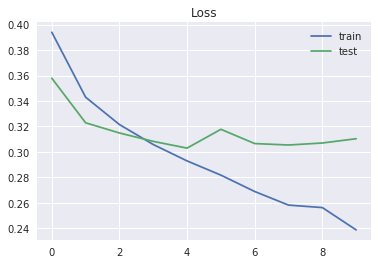

In [282]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

/home/theosimier/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


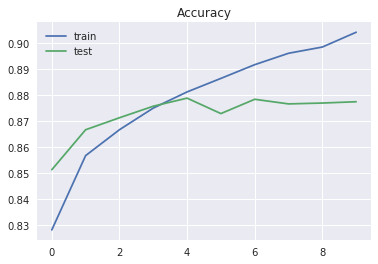

In [283]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [ ]:
test_probabilities = model_1.predict([X_test,statistical_features_test])
test_labels = (test_probabilities > 0.5).astype(np.int)
confusion_matrix(Y_test, test_labels)

array([[4290,  786],
       [ 433, 4491]])

# Appendix

## GridSearch

In [ ]:
# Hyperparameters
## Stables
epochs = 14
## To tune
grid_search_parameters = {'batch_size':[60, 100]}

In [ ]:
def get_model_2():
    # Input
    main_input = Input(shape=(50,),dtype='int32', name='main_input')
    # Embedding
    glove_embedding = Embedding(vocab_size, 100, weights=[glove_embedding_matrix], input_length=X.shape[1], trainable=False)
    embedded_sequences = glove_embedding(main_input)
    # Other Layer
    x = SpatialDropout1D(0.2)(embedded_sequences) # It drops entire 1D feature maps instead of individual elements
    x = Bidirectional(LSTM(200))(x)
    # Statistical Features
    statistical_features = Input(shape=(7,), name='statistical_features')
    x2 = Dense(128, activation='relu')(statistical_features)

    x = concatenate([x, x2])
    x = Dense(64, activation='relu')(x)
    # Prediction
    preds = Dense(1, activation='sigmoid')(x)
    # model
    model_2 = Model([main_input,statistical_features], preds)
    model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_2

In [ ]:
keras_model = KerasClassifier(build_fn=get_model, epochs=epochs)

# Callback
nb_epoch_before_stop = 3
min_delta=0.0001
c = [EarlyStopping(monitor='val_loss', patience=nb_epoch_before_stop, min_delta=min_delta)] # Callback: We stop after 5 epochs
# GridSearchCV
clf = GridSearchCV(keras_model, grid_search_parameters, cv=5)
# Fitting
validation_split = 0.2
clf.fit([X,statistical_features_matrix.todense()],Y, validation_split = 0.2,callbacks=c) # validation_split = validation_split, 

## Embedding without Glove

### Structure of the Neural Network

In [ ]:
model = Sequential()
model.add(Embedding(max_nb_words, embedding_dimension, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.1))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 20
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)])

In [ ]:
print(model.summary())

### Results

In [ ]:
model.predict(X_test)[:5]

In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

## How to train our own embedding ?

##### Training own model demo

In [ ]:
sentences = data_lemma_list[:20]  # The data used to train a Word2Vec model has to be tokenize sentences.
model = Word2Vec(sentences, size=100, window=5, min_count=1, workers=2) # We train the model.

In [ ]:
words = list(model.wv.vocab)  # Vocabulary of the model
print(words[:10])

In [ ]:
#model.wv['travel']  # The word business is represented by a vector of 100 dimensions. or print(model['business'])

##### Visualization

In [ ]:
X = model[model.wv.vocab] # We use the matrix of vectors as data
pca = PCA(n_components=2) # We create our PCA object
result = pca.fit_transform(X) # We fit it
plt.scatter(result[:, 0], result[:, 1]); # We plot it

In [ ]:
### How can we explore the vocabulary ? 

##### pretrain model glove

In [ ]:
# load the Stanford GloVe model
filename = 'glove.6B.50d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)
# calculate: (king - man) + woman = ?
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
del model
print(result)